<a href="https://colab.research.google.com/github/hida0/ESAA/blob/HW/Week13_HW1_%ED%9A%8C%EA%B7%80_%EC%8B%A4%EC%8A%B5_%EC%9E%90%EC%A0%84%EA%B1%B0_%EC%88%98%EC%9A%94_%EC%A3%BC%ED%83%9D_%EA%B0%80%EA%B2%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 개념 정리 & 필사
(파이썬 머신러닝 완벽가이드  ch5. 9-10 pg. 342-375)


## 회귀 실습 - 자전거 대여 수요 예측
- 자전거 대여 수요 데이터는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어 있다.
- 결정값은 맨 마지막 칼럼인 count로, 대여 횟수를 의미한다.

> 데이터 세트의 주요 칼럼은 다음과 같다.
 - datatime: hourly date + timestamp
 - season: 1=봄, 2=여름, 3=가을, 4=겨울
 - holiday: 1=토, 일요일의 주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌 날
 - workingday: 1=토, 일요일의 주말 및 휴일이 아닌 주중, 0=주말 및 휴일
 - weather: 1=맑음, 약간 구름 낀 흐림,  2= 안개, 안개+흐림, 3=가벼운 눈, 가벼운 비+천둥, 4= 심한 눈/비, 천둥/번개
 - temp: 온도(섭씨)
 - atemp: 체감온도(섭씨)
 - humidity: 상대습도
 - windspeed: 풍속
 - casual: 사전에 등록되지 않는 사용자가 대여한 횟수
 - registered: 사전에 등록된 사용자가 대여한 횟수
 - count: 대여 횟수

### 1. 데이터 전처리 및 가공
- 데이터를 DataFrame으로 로드하여 살펴보면 10886개의 자료와 12개의 칼럼으로 구성되어 있다.
- 10886개의 행 데이터 중 Null 데이터는 없으며, 대부분의 칼럼이 int형 또는 float형이고 datatime 칼럼만 object형이다. 
- datetime 칼럼을 년, 월, 일, 시간의 4개의 속성으로 분리한다. 판다스는 datetime 타입만 분리할 수 있기 때문에, object형인 datetime 칼럼을 **`apply(pd.to_datatime)`** 메서드를 이용하여 **datetime 형으로 변경**한다. 
- datetime 형으로 변경된 칼럼에 **`apply(lambda)`** 함수를 이용하여 년, 월, 일, 시간 칼럼으로 추출하고, 기존 datetime 칼럼은 삭제한다.
- 사전에 등록하지 않은 사용자의 대여 횟수인 causal 칼럼과 사전에 등록한 사용자의 대여 횟수 registered 칼럼의 합이 count 칼럼과 동일하다. 따로 필요하지 않으며 상관도가 높아 예측을 저해할 우려가 있으므로 두개의 칼럼도 삭제한다.

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv("/content/drive/MyDrive/ESAA/data/bike_train.csv")
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
# 문자열 datetime 칼럼을 datetime 형으로 변경
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime)

# datetime 형인 datetime 칼럼으로부터 년, 월, 일, 시간 칼럼을 추출
bike_df['year'] = bike_df['datetime'].apply(lambda x: x.year)
bike_df['month'] = bike_df['datetime'].apply(lambda x: x.month)
bike_df['day'] = bike_df['datetime'].apply(lambda x: x.day)
bike_df['hour'] = bike_df['datetime'].apply(lambda x: x.hour)

# datetime 칼럼과 causal, registered 칼럼을 삭제
bike_df.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)

bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


### 1. 데이터 전처리 및 가공
- 다양한 회귀 모델을 데이터 세트에 적용하여 예측 성능을 측정한다.
- RMSLE(Root Mean Square Log Error), MSE, RMSE를 한꺼번에 평가하는 성능 평가 함수 evaluate_regr( )를 생성한다.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용하여 RMSLE를 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용하여 RMSE를 계산
def rmse(y, pred):
    rmse = np.sqrt(mean_squared_error(y, pred))
    return rmse

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print("RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}".format(rmsle_val, rmse_val, mae_val))

### 2. 로그 변환, 피처 인코딩과 모델 학습/예측/평가
- 회귀 모델을 이용하여 자전거 대여 횟수를 예측한다. 
- 회귀 모델을 적용하기 전 데이터 세트에 대해서 먼저 처리해야 하는데, **결과값이 정규 분포로 되어있는지 확인**하는 것과 카테고리형 회귀 모델의 경우 **원-핫 인코딩으로 피처를 인코딩**하는 것이다.
- 선형 회귀 모델을 적용하면서 다음과 같은 두 가지 사항을 확인한다.
- 아무런 변환 없이 얻은 예측값을 평가해보면 예측 오류가 비교적 크게 나타난다. 실제값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류값이 가장 큰 순서로 5개를 확인한다. 이를 위해 함수 get_top_error_data( )를 생성한다.

In [ ]:
y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [ ]:
def get_top_error_data(y_test, pred, n_tops=5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])

    # 예측값이 실제값의 차이가 가장 큰 데이터 순서로 출력
    return result_df.sort_values('diff', ascending=False)[: n_tops]

get_top_error_data(y_test, pred, n_tops=5)

,real_count,predicted_count,diff
1618,890,322.0,568.0
3151,798,241.0,557.0
966,884,327.0,557.0
412,745,194.0,551.0
2817,856,310.0,546.0


### 2. 로그 변환, 피처 인코딩과 모델 학습/예측/평가
- 상위 5위 오류값은 546~568로, 실제값을 감안하면 예측 오류가 꽤 크다.
- 회귀에서 이렇게 큰 **예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포**이다. **Target 값의 분포는 정규 분포 형태**가 가장 좋으며, 왜곡된 형태를 이루고 있다면 회귀 예측 성능이 저하되는 경우가 발생하기 쉽다.
- 판다스의 `hist( )`를 이용하여 데이터 세트의 Target 값인 count 칼럼이 정규 분포를 이루고 있는지 확인하면, count 칼럼 값이 정규 분포가 아닌 0~200 사이에 왜곡되어 있는 것을 알 수 있다.
- 이렇게 **왜곡된 데이터 값을 정규 분포 형태로** 바꾸는 가장 일반적인 방법은 **로그를 적용하여 변환**하는 것이다. 
---
- 넘파이의 **`log1p( )`** 함수를 이용하여 Target 값을 로그 변환한다. 변경된 Target 값을 기반으로 학습하고 예측한 값은, 다시 **`expm1( )`** 함수를 적용하여 원래 scale 값으로 원상 복구한다.
- 로그 변환을 위해 **`log1p( )`**를 적용한 count 칼럼의 분포를 `hist( )`를 이용하여 그려보면, 원하는 정규 분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상된 것을 확인할 수 있다. 이를 이용하여 다시 학습하고 평가를 수행한다.

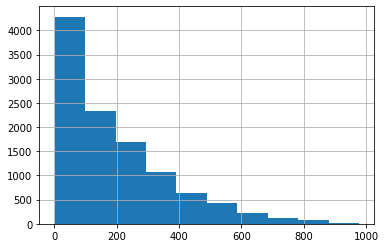

In [ ]:
import matplotlib.pyplot as plt
y_target.hist()
plt.show()

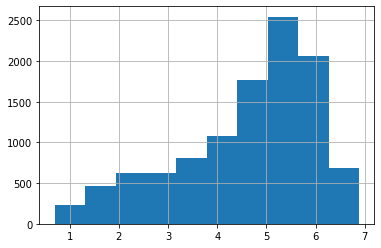

In [ ]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()
plt.show()

In [ ]:
# 타겟 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환되었으므로 다시 expm1()를 이용하여 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타겟 기반으로 학습되어 예측됐으므로 다시 expm1()로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


### 2. 로그 변환, 피처 인코딩과 모델 학습/예측/평가
- 이전: [RMSLE: 1.165, RMSE: 140.900, MAE: 105.924] -> 이후: [RMSLE: 1.017, RMSE: 162.594, MAE: 109.286]
- RMSLE 오류는 감소했지만, RMSE는 오히려 더 늘어났다. 
- 이유를 알아보기 위해 각 피처의 회귀 계수 값 **`coef_`**을 seaborn의 `barplot( )`을 이용하여 시각화한다.
- 그림을 살펴보면 Year 피처의 회귀 계수 값이 독보적으로 큰 값을 가지고 있음을 알 수 있다.
- year 피처는 연도를 뜻하므로 카테고리형 피처지만, 숫자형 값을 가지며 그 값은 2011, 2012로 아주 크다. 사이킷런은 카테고리만을 위한 데이터 타입이 없으므로 모두 숫자로 변환해야 한다. 그러나 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 큰 영향을 받는 경우가 발생할 수 있다.
- 따라서 선형 회귀에서는 이러한 피처 인코딩에 **원-핫 인코딩**을 적용하여 변환해야 한다.

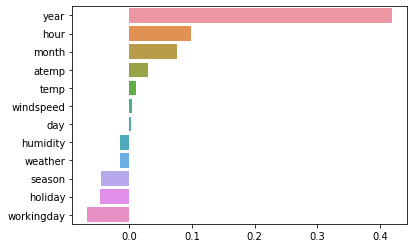

In [ ]:
import seaborn as sns

# 회귀 계수를 추출하여 Series를 생성
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

### 2. 로그 변환, 피처 인코딩과 모델 학습/예측/평가
- 피처 인코딩에 **원-핫 인코딩**을 적용하기 위해서 판다스의 **`get_dummies( )`**를 이용한다.
- year 칼럼을 비롯하여 month, day, hour, holiday, working, season, weather 칼럼을 모두 원-핫 인코딩한 후에 다시 예측 성능을 확인한다.
- 사이킷런의 선형 회귀 모델인** LinearRegression, Ridge, Lasso**를 모두 학습하여 예측 성능을 확인하기 위해, 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환하는 get_model_predict( ) 함수를 생성한다.
- 원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상되었다.
---
- 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화해보기 위해 회귀 계수 상위 25개 피처를 추출한다. month_9, month_8, month_7 등 월 관련 피처들과 holiday 등 월, 주말/주중 등 상식선에서 자전거를 타는데 필요한 피처의 회귀 계수가 높아졌다. 
- 이처럼 선형 회귀 수행 시에는 피처를 어떻게 인코딩하는가가 성능에 큰 영향을 미칠 수 있다.

In [ ]:
# 피처를 원-핫 인코딩
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [ ]:
# 원-핫 인코딩이 적용된 피처 데이터 세트를 기반으로 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)  # 실제값 지수 변환
        pred = np.expm1(pred)  # 예측값 지수 변환
    print( "###", model.__class__.__name__, "###")
    evaluate_regr(y_test, pred)

from sklearn.linear_model import Ridge, Lasso
# 모델별로 평가를 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


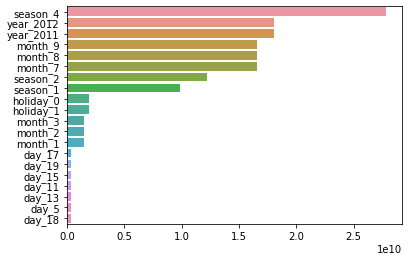

In [ ]:
# 회귀 계수를 추출하여 Series를 생성
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

### 2. 로그 변환, 피처 인코딩과 모델 학습/예측/평가
- 앞에서 적용한 Target 값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 이용하여, **회귀 트리**를 이용한 회귀 예측을 수행한다.
- **랜덤 포레스트, GBM, XGBoost, LightGBM**을 이용하여 순차적으로 성능을 평가한다.
- XGBoost의 경우 DataFrame이 학습/테스트 데이터로 입력될 경우 오류가 발생할 수 있으므로 학습/테스트 데이터를 DataFrame의 values 속성을 이용해 넘파이 ndarray로 변환한다.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별 평가를 수행
rf_reg = RandomForestRegressor(n_estimators=1000)
gbm_reg = GradientBoostingRegressor(n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgbm_reg = LGBMRegressor(n_estimators=1000)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력될 경우 오류 발생 가능성이 있으므로 ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.191, MAE: 31.118
### GradientBoostingRegressor ###
RMSLE: 0.321, RMSE: 50.678, MAE: 31.033
[15:54:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.321, RMSE: 50.770, MAE: 31.156
### LGBMRegressor ###
RMSLE: 0.321, RMSE: 47.833, MAE: 29.144


## 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법
- 79개의 변수로 구성된 이 데이터는 미국 아이오와 주의 에임스 지방의 주택 가격 정보를 가지고 있다.
- **성능 평가**는 앞의 자전거 대여 예측과 동일하게 **RMSLE**를 기반으로 한다. 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 이용하는 것이다.


### 1. 데이터 사전 처리
- 데이터를 DataFrame으로 로드한다. 데이터 가공을 많이 수행할 예정이므로 원본 DataFrame은 보관하고, 복사하여 데이터를 가공한다.
- Target 값은 맨 마지막 칼럼인 SalePrice이다. 
- 데이터 세트의 전체 크기와 모든 칼럼의 타입, Null이 있는 칼럼을 살펴본다. 모든 칼럼의 타입은 `dtypes`를 이용하여 확인하며, Null이 있는 칼럼의 각각의 건수를 구하여 내림차순으로 출력한다.
- 데이터 세트는 1460개의 자료와 81개의 피처로 구성되어 있으며, 피처의 타입으로는 숫자형과 문자형 모두 존재하는데, Target을 제외한 80개의 피처 중 43개가 문자형이고 나머지가 숫자형이다.
- 전체 1480개의 데이터 중 PoolQC, MiscFeature, Alley, Fence는 Null 값이 1000개를 넘어 데이터 양에 비해 너무 많으므로 피처를 드롭한다.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv("/content/drive/MyDrive/ESAA/data/house_price.csv")  # 원본 데이터
house_df = house_df_org.copy()  # 복사한 데이터
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
print("데이터 세트의 Shape: ", house_df.shape)
print("\n전체 피처의 type\n", house_df.dtypes.value_counts())

isnull_series = house_df.isnull().sum()
print("\nNull 칼럼과 그 건수\n", isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 Shape:  (1460, 81)

전체 피처의 type
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


### 1. 데이터 사전 처리
- 회귀 모델을 적용하기 전 **타겟값의 분포도가 정규 분포인지 확인**한다.
- `hist( )`를 이용하여 그려보면 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로 정규 분포에서 벗어나 있음을 알 수 있다.
- 정규 분포가 아닌 결과값을 정규 분포 형태로 변환하기 위해  **로그 변환**을 적용한다.
- 넘파이의 `log1p( )`를 이용하여 로그 변환한 결과값을 기반으로 학습하고, 예측 시에는 다시 결과값을 `expm1( )`로 추후에 환원한다.
- SalePrice 칼럼을 로그 변환하고 다시 분포도를 살펴보면 정규 분포 형태로 결과값이 분포함을 확인할 수 있다.
---
- Null 값이 많은 피처인 PoolQC, MiscFeature, Alley, Fence, FireplaceQu 칼럼과, 단순 식별자인 Id 칼럼을 삭제한다.
- LotFrontage는 Nul 값이 259개로 비교적 많으나 평균값으로 대체하고, 나머지 Null 피처는 Null 값이 많지 않으므로 숫자형의 경우 평균값으로 대체한다.
- 이를 위해 DataFrame 객체의 **`mean( )`** 메서드를 사용하는데, 이는 자동으로 숫자형 칼럼만을 추출하여 **칼럼별 평균값을 Series 객체로 반환**한다.
---
- 숫자형 칼럼의 Null 값을 칼럼별 평균값으로 대체하면, 문자형 칼럼을 제외하고는 Null 값이 존재하지 않는다.
- 문자형 피처는 모두 판다스의 **`get_dummies( )`**를 이용하여 **원-핫 인코딩**으로 변환한다.
- `get_dummies( )`는 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null 값은 'None' 칼럼으로 대체해주기 때문에 별도의 Null 값을 대체하지 않아도 된다.
- 원-핫 인코딩을 적용하면 당연히 칼럼의 수가 증가한다.  피처가 75개에서 272개로 증가하였으며, Null 값을 가진 피처는 존재하지 않는다.

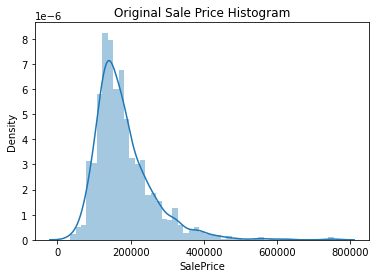

In [ ]:
# 타겟값의 분포도 확인
plt.title("Original Sale Price Histogram")
sns.distplot(house_df['SalePrice'])
plt.show()

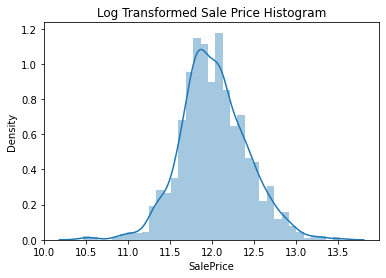

In [ ]:
# 로그 변환 적용 후 타겟값의 분포도 확인
plt.title("Log Transformed Sale Price Histogram")
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)
plt.show()

In [ ]:
# 타겟값을 로그변환하여 DataFrame에 반영
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 Id 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print(" ## Null 피처의 Type: \n", house_df.dtypes[null_column_count.index])

 ## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [ ]:
print("get_dummies( ) 수행 전 데이터 Shape: ", house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print("get_dummies( ) 수행 후 데이터 Shape: ", house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print(" ## Null 피처의 Type: \n", house_df_ohe.dtypes[null_column_count.index])

get_dummies( ) 수행 전 데이터 Shape:  (1460, 75)
get_dummies( ) 수행 후 데이터 Shape:  (1460, 271)
 ## Null 피처의 Type: 
 Series([], dtype: object)


### 2. 선형 회귀 모델 학습/예측/평가
- 예측 평가는 실제값과 예측값의 오류를 로그 변환한 뒤 RMSE를 적용하는 RMSLE를 이용한다.
- 이미 타겟값인 SalePrice가 로그 변환되었고, 예측값 역시 로그 변환된 SalePrice를 기반으로 예측하므로 원본 SalePrice 예측값의 로그 변환과 같다. 
- 따라서 실제값도 로그 변환되었고, 예측값도 이를 반영한 로그 변환 값이므로 **예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정**된다.
- 여러 모델의 로그 변환된 RMSE를 측정할 것이므로 이를 위한 유틸리티 함수 get_rmse( )와 get_rmses( )를 생성한다.
---
- **LinearRegression, Ridge, Lasso** 모델에 대하여 학습, 예측, 평가를 수행한다.
- 라쏘 회귀의 경우 회귀 성능이 타 방식보다 많이 떨어지는 결과가 나왔으므로, 최적 하이퍼 파라미터 튜닝이 필요해보인다.

In [ ]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, " 로그 변환된 RMSE: ", np.round(rmse, 3))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop("SalePrice", axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression  로그 변환된 RMSE:  0.132
Ridge  로그 변환된 RMSE:  0.128
Lasso  로그 변환된 RMSE:  0.176


[0.13189576579154202, 0.12750846334052995, 0.17628250556471403]

### 2. 선형 회귀 모델 학습/예측/평가
- **피처별 회귀 계수를 시각화**하여 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인한다.
- 피처가 많으므로 회귀 계수 값의 상위 10개와 하위 10개의 피처명과 그 회귀 계수 값을 추출한다. 이 값들을 판다스 Series 객체로 반환하는 함수 get_top_bottom_coef( )를 생성한다.
- 모델별 회귀 계수를 시각화하기 위해 list 객체로 모델을 입력 받아 모델별로 회귀 계수 상위 10개와 하위 10개를 추출하여 가로 막대 그래프 형태로 출력하는 함수 visualize_coefficient( )를 생성한다.
- LinearRegression, Ridge, Lasso 모델의 회귀 계수를 시각화한다. 
---
- 모델별 회귀 계수를 살펴보면 OLS 기반의 LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포한다.
- 그러나 Lasso는 다른 두개의 모델과 다른 회귀 계수의 형태를 보인다. 전체적으로 회귀 계수 값이 매우 작고, YearBuilt가 다른 피처에 비해 매우 크다.


In [ ]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성하며, index는 칼럼명으로 지정
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개와 - 하위 10개의 회귀 계수를 추출하여 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

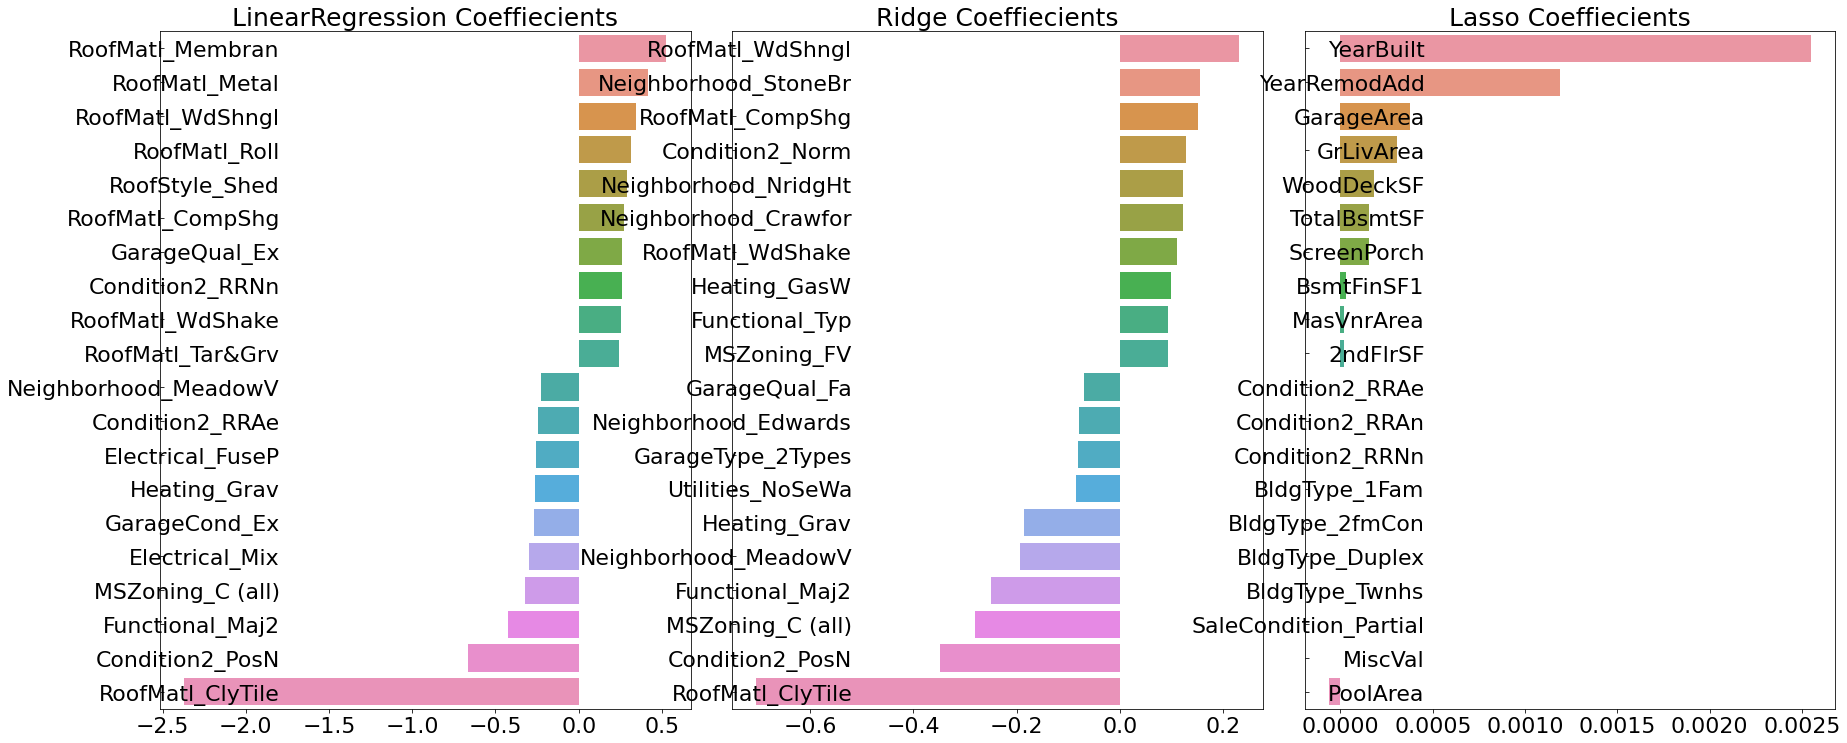

In [ ]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()

    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출하여 회귀 계수를 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하여 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 font 크기를 조정
        axs[i_num].set_title(model.__class__.__name__+" Coeffiecients", size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞의 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 2. 선형 회귀 모델 학습/예측/평가
- 이와 같은 차이점이 혹시 학습 데이터의 데이터 분할에 문제가 있어서 그런 것인지 판단하기 위하여 데이터 분할을 다르게 해 본다.
-  학습과 테스트 세트를 `train_test_split( )`을 이용하여 분할하지 않고, 전체 데이터 세트인 X_features와 y_target을 5개의 **교차 검증 폴드 세트로 분할**하여 평균 RMSE를 측정한다. 이를 위하여 **`cross_val_score( )`**를 이용하며, 평가를 위한 함수 get_avg_rmse_cv( )를 생성한다.
- LinearRegression, Ridge, Lasso RMSE 값을 구한다.
- 5개의 폴드 세트로 학습한 후 평가하여도 여전히 Lasso의 경우가 OLS 기반의 LinearRegression 모델이나 Ridge 모델보다 성능이 떨어진다.
---
- 릿지와 라쏘 모델에 대해 **`GridSearchCV`**를 이용하여 **`alpha`** 하이퍼 파라미터를 변화시키면서 최적의 값을 도출한다.
- 모델별로 최적화 하이퍼 파라미터 작업을 반복적으로 진행하므로 이를 위한 별도의 함수 print_best_params( )를 생성한다. 이 함수는 모델과 하이퍼 파라미터 딕셔너리 객체를 입력받아 최적화 작업의 결과를 표시한다.
- 이를 이용하여 릿지 모델과 라쏘 모델의 최적화 alpha 값을 추출한다.
- 릿지 모델의 경우 alpha가 12에서 최적 평균 RMSE가 0.1418, 라쏘 모델의 경우 alpha가 0.001에서 최적 평균 RMSE가 0.142이다.  
- 라쏘 모델의 경우 alpha 값 최적화 이후 평균 RMSE가 0.198에서 0.142로, 예측 성능이 많이 좋아졌다.

In [ ]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score()을 수행하여 모델별 CV RMSE 값과 평균 RMSE를 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print("\n{0} CV RMSE 값 리스트: {1}".format(model.__class__.__name__, np.round(rmse_list, 3)))
        print("{0} CV 평균 RMSE 값: {1}".format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞의 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값을 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print("{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha: {2}".format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.03, 0.05, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha: {'alpha': 0.001}


### 2. 선형 회귀 모델 학습/예측/평가
- 릿지 모델의 최적 alpha 값은 12, 라쏘 모델의 최적 alpha 값은 0.001이다. 
- 선형 모델에 다음의 최적 alpha 값을 설정한 뒤, `train_test_split( )`으로 분할된 학습 데이터와 테스트 데이터를 이용하여 모델의 학습/예측/평가를 수행하고 모델별 회귀 계수를 시각화한다.
---
- alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아졌다. 릿지 모델은 0.1418에서 0.124로, 라쏘 모델은 0.142에서 0.12로 평균 RMSE가 감소하였다.
- 모델별 회귀 계수도 많이 달라졌다. 기존에는 라쏘 모델의 회귀 계수가 나머지 두 개의 모델과 많은 차이가 있었지만, 릿지 모델과 라쏘 모델에서 비슷한 피처의 회귀 계수가 높다.

LinearRegression  로그 변환된 RMSE:  0.132
Ridge  로그 변환된 RMSE:  0.124
Lasso  로그 변환된 RMSE:  0.12


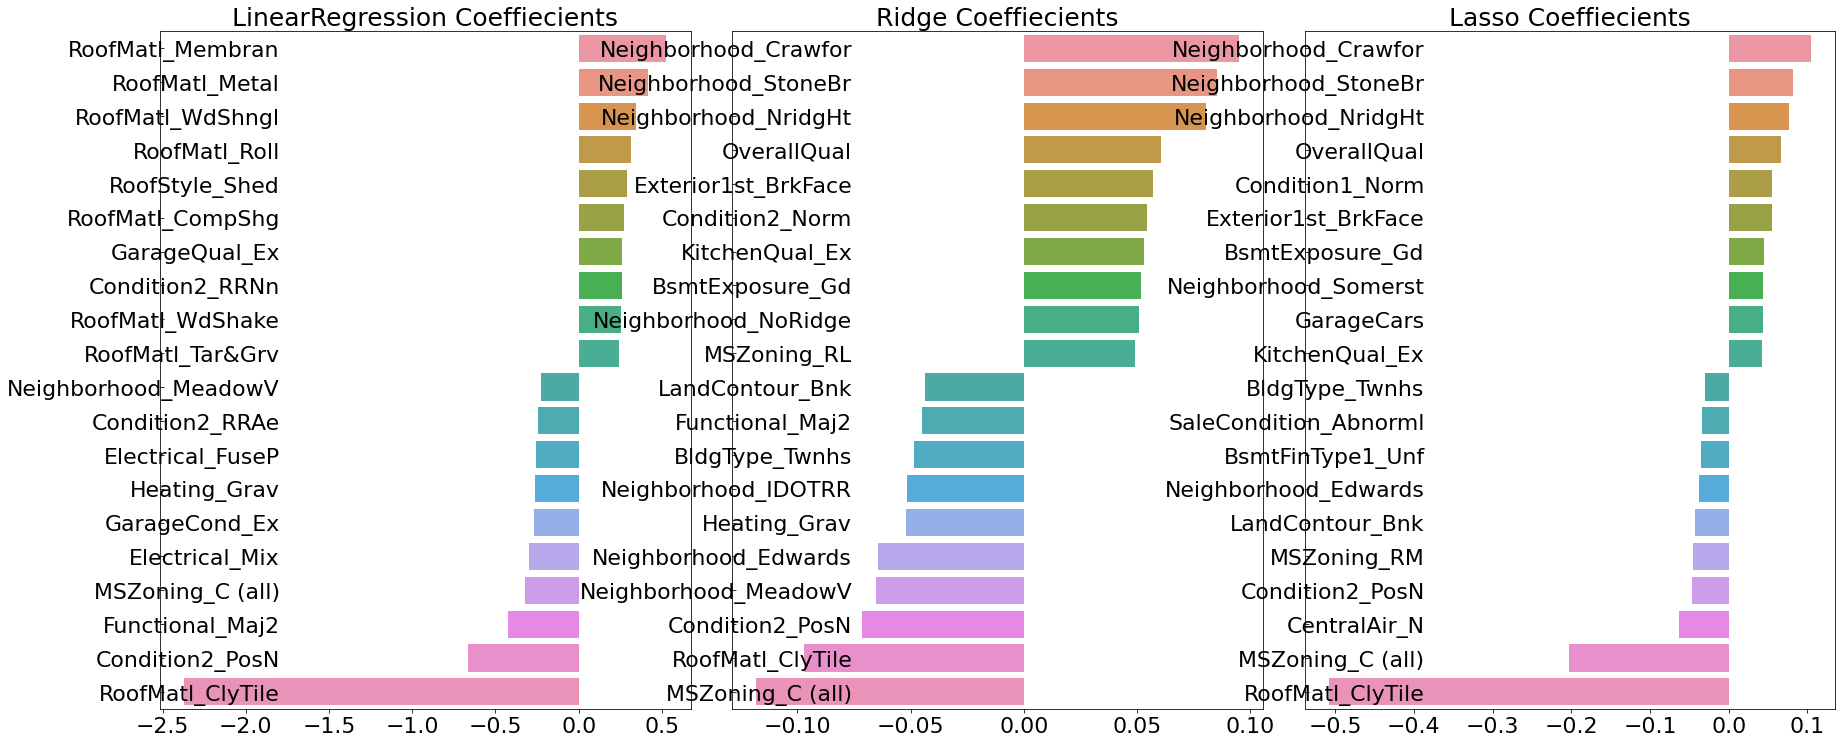

In [ ]:
# 앞의 최적화 alpha 값을 이용하여 학습 데이터로 학습, 테스트 데이터로 예측 및 평가를 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE를 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수를 시각화
visualize_coefficient(models)

### 2. 선형 회귀 모델 학습/예측/평가
- 데이터 세트에 추가적인 가공을 진행하여 모델 튜닝을 좀 더 진행한다. 첫번째는 **피처 데이터 세트의 데이터 분포도**를 살펴보고, 두번째는 **이상치 데이터를 처리**한다.
- 먼저 첫번째로 피처 데이터 세트의 분포도를 확인한다. 타겟 데이터 세트와 마찬가지로 피처 데이터 세트의 경우에도 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬 수 있다. 
- 모든 숫자형 피처의 데이터 분포도를 확인하여 분포도가 어느 정도로 왜곡되었는지 알아본다. 사이파이 **stats** 모듈의 **`skew( )`** 함수를 이용하면 칼럼의 데이터 세트의 **왜곡된 정도를 추출**할 수 있다.
- 일반적으로 `skew( )` 함수의 **반환 값이 1 이상인 경우를 왜곡 정도가 높다**고 판단하지만 상황에 따라 편차가 있다. DataFrame에서 숫자형 피처의 왜곡 정도를 확인하는데, 1 이상의 값을 반환하는 피처만 추출하여 **왜곡 정도를 완화하기 위해 로그 변환**을 적용한다.
- `skew( )`를 적용하는 숫자형 피처에서 **원-핫 인코딩된 카테고리 숫자형 피처는 제외**해야 하므로, 원-핫 인코딩이 적용된 house_df_ohe가 아닌 적용되지 않은 house_df에 함수를 적용한다.
---
- house_df의 피처를 일부 로그 변환하였으므로 다시 원-핫 인코딩을 적용한 house_df_ohe를 생성한다. 그리고 이에 기반한 피처 데이터 세트와 타겟 데이터 세트, 학습/테스트 데이터 세트를 다시 만든다.
- 이렇게 만든 데이터 세트에 앞에서 생성한 print_best_params( ) 함수를 이용하여 최적 alpha 값과 RMSE를 출력한다. 

In [ ]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != "object"].index

# housd_df에 칼럼 index를 [ ]로 입력하여 해당하는 칼럼 데이터 세트를 반환하고 apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))

# skew 값이 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [ ]:
# 추출된 왜곡 정도가 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [ ]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하여 피처/타겟 데이터 세트를 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 최적 하이퍼 파라미터와 RMSE를 출력
ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.03, 0.05, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha: {'alpha': 0.001}


### 2. 선형 회귀 모델 학습/예측/평가
- 릿지 모델의 경우 최적 alpha 값이 12에서 10으로 변경되었고, 두 모델 모두 피처의 로그 변환 이전과 비교하여 5 폴드 교차 검증의 평균 RMSE 값이 릿지는 0.1418에서 0.1275로, 라쏘는 0.142에서 0.1252로 향상되었다.
- 학습 데이터와 테스트 데이터를 이용하여 모델의 학습/예측/평가를 수행하고, 모델별 회귀 계수를 시각화한다.
- 시각화 결과를 보면 세 모델 모두 GrLivArea, 즉 주거 공간 크기가 회귀 계수가 가장 높은 피처가 되었다. 주거 공간의 크기가 주택 가격에 미치는 영향이 제일 높을 것이라는 상식선에서의 결과가 도출되었다.

LinearRegression  로그 변환된 RMSE:  0.128
Ridge  로그 변환된 RMSE:  0.122
Lasso  로그 변환된 RMSE:  0.119


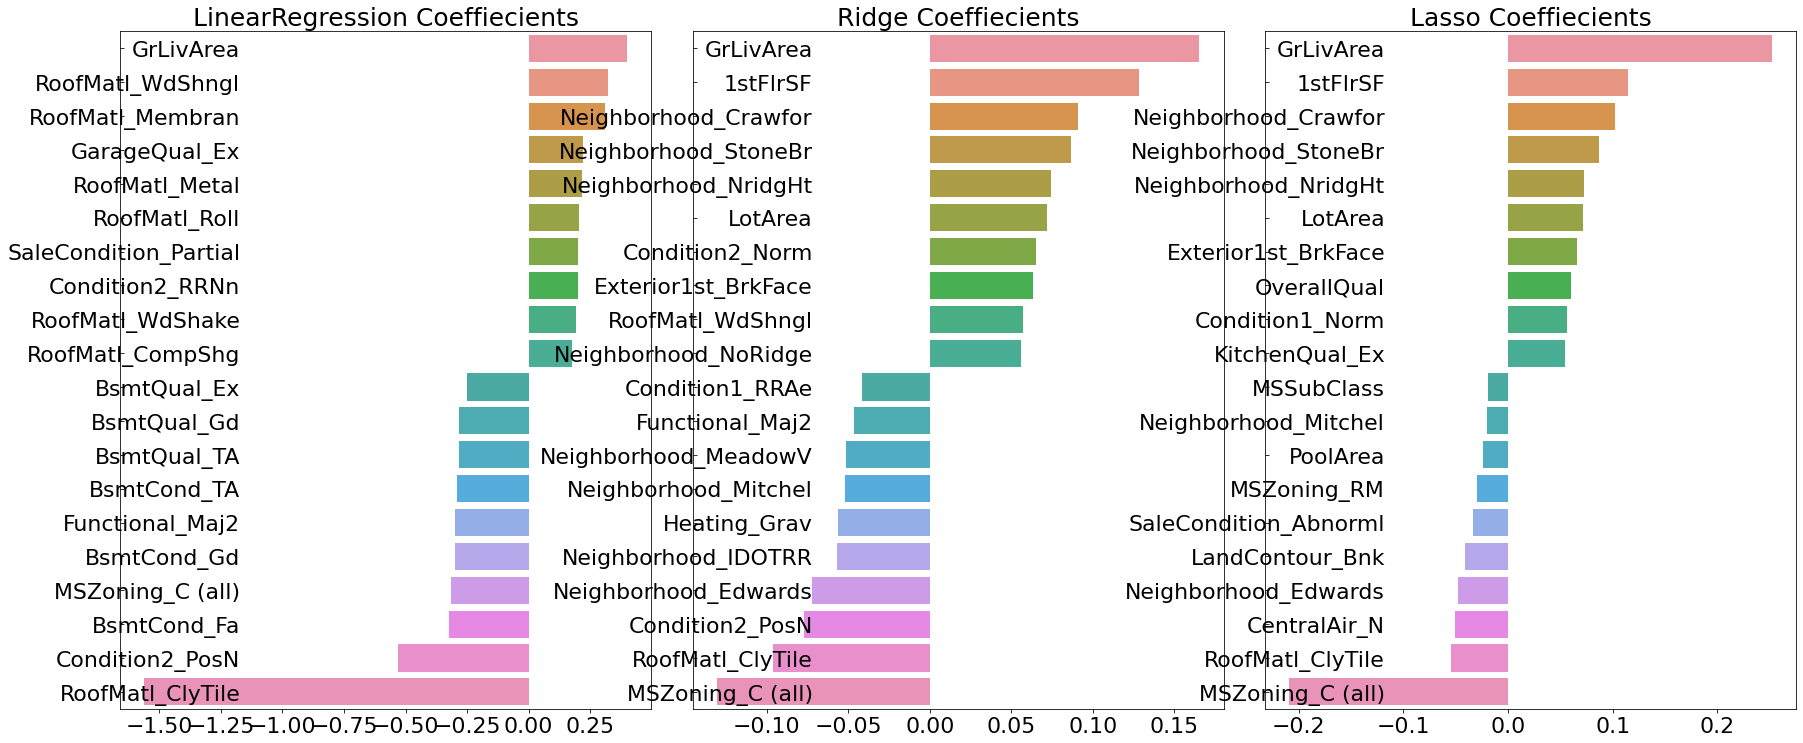

In [ ]:
# 최적화 alpha 값을 이용하여 학습 데이터로 학습, 테스트 데이터로 예측 및 평가를 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE를 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수를 시각화
visualize_coefficient(models)

### 2. 선형 회귀 모델 학습/예측/평가
- 데이터 세트에 추가적인 가공을 진행하여 모델 튜닝을 좀 더 진행한다. 첫번째는 **피처 데이터 세트의 데이터 분포도**를 살펴보고, 두번째는 **이상치 데이터를 처리**한다.
- 두번째로 이상치 데이터에 대하여 분석한다.
- 특히 회귀 계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터 처리가 중요하다. 세 개의 모델 모두에서 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포를 살펴본다.
- 주택 가격 데이터가 변환되기 이전 원본 데이터 세트인 house_df_org에서 GrLivArea와 타겟값인 SalePrice의 관계를 시각화한다.
- 일반적으로 주거 공간이 큰 집일수록 주택 가격이 비싸기 때문에 GrLivArea는 SalePrice와 양의 상관도가 매우 높다. 그러나 두 개의 데이터가 일반적인 GrLivArea와 SalePrice의 관계에서 어긋나 있다.
---
- 데이터 변환이 모두 완료된 house_df_ohe에서 대상 데이터를 필터링한다.
- GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건을 생성하고 불린 인덱싱으로 대상을 찾는다. DataFrame에서 해당 데이터를 삭제한다.
- 업데이트 된 house_df_ohe를 기반으로 피처 데이터 세트와 타겟 데이터 세트, 학습/테스트 데이터 세트를 생성하고 앞에서 정의한 print_best_params( ) 함수를 이용하여 릿지와 라쏘 모델이 최적화를 수행하여 결과를 출력한다.
- 웬만큼 하이퍼 파라미터 튜닝을 해도 엄청난 수치 개선은 어렵지만, GrLivArea 속성이 회귀 모델에서 차지하는 영향도가 크기에 이러한 이상치를 개선하는 것이 성능 개선에 큰 의미를 갖는다.
--- 
- 이상치가 제거된 데이터 세트를 기반으로 다시 `train_test_split( )`로 분할된 데이터 세트의 RMSE 수치 및 회귀 계수를 시각화한 결과는 다음과 같다.

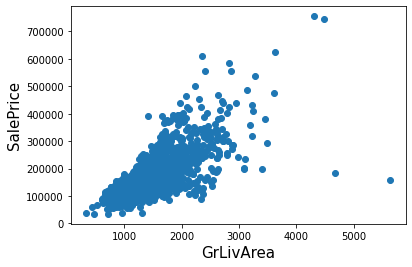

In [ ]:
plt.scatter(x=house_df_org["GrLivArea"], y=house_df_org["SalePrice"])
plt.ylabel("SalePrice", fontsize=15)
plt.xlabel("GrLivArea", fontsize=15)
plt.show()

In [ ]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건을 생성
cond1 = house_df_ohe["GrLivArea"] > np.log1p(4000)
cond2 = house_df_ohe["SalePrice"] > np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print("이상치 레코드 index: ", outlier_index.values)
print("이상치 삭제 전 house_df_ohe shape: ", house_df_ohe.shape)

# DataFrame의 인덱스를 이용하여 이상치 레코드를 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print("이상치 삭제 후 house_df_ohe shape: ", house_df_ohe.shape)

이상치 레코드 index:  [ 691 1182]
이상치 삭제 전 house_df_ohe shape:  (1460, 271)
이상치 삭제 후 house_df_ohe shape:  (1458, 271)


In [ ]:
# 업데이트 된 데이터를 이용하여 피처 데이터 세트와 타겟 데이터 세트, 학습/테스트 데이터 세트를 생성
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.03, 0.05, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1272, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1249, 최적 alpha: {'alpha': 0.001}


LinearRegression  로그 변환된 RMSE:  0.119
Ridge  로그 변환된 RMSE:  0.107
Lasso  로그 변환된 RMSE:  0.101


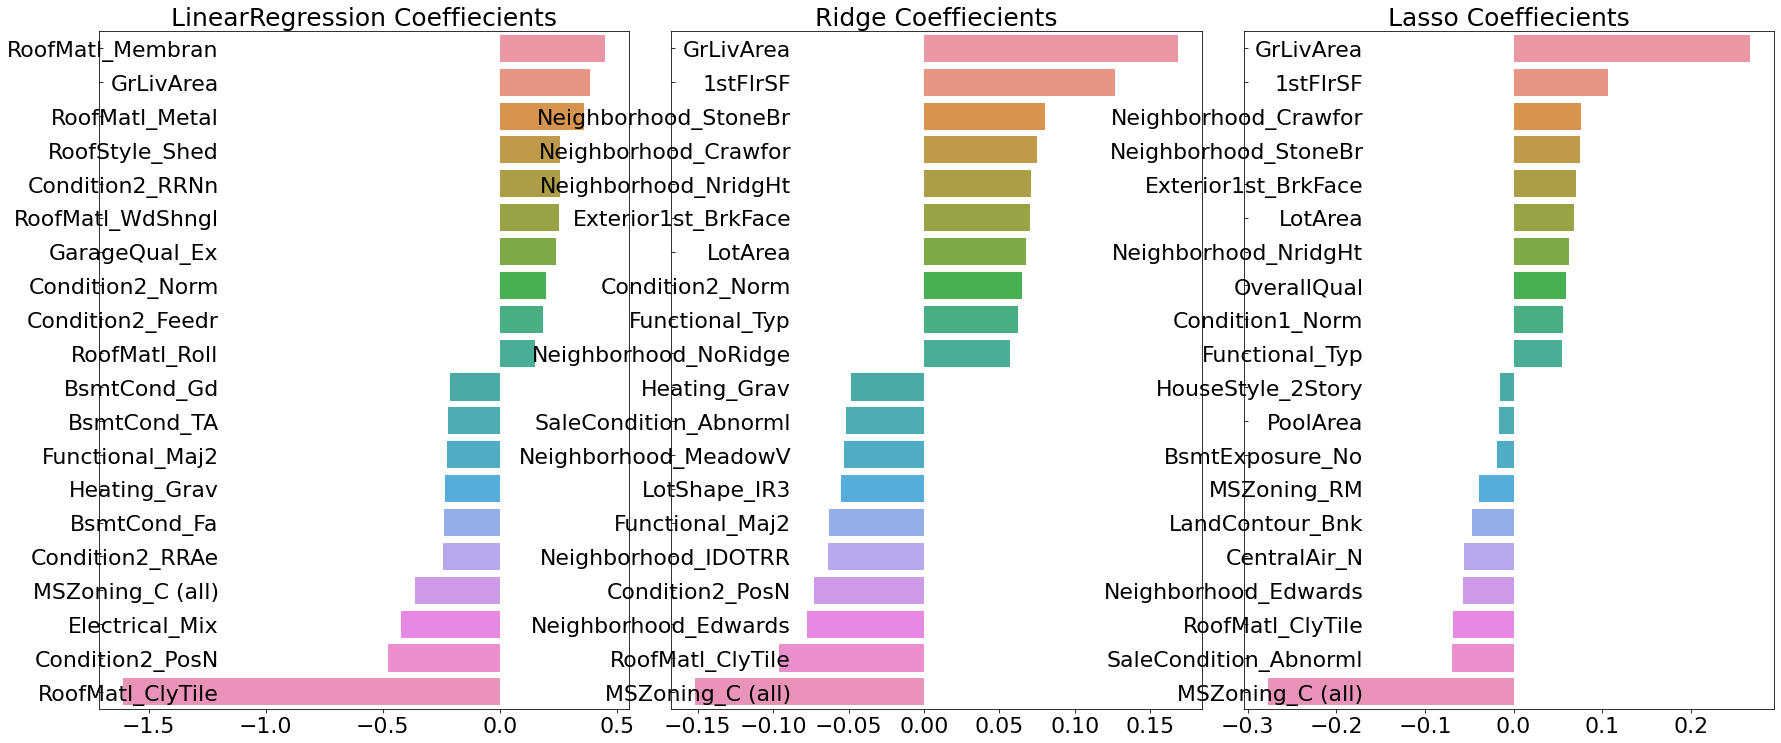

In [ ]:
# 최적화 alpha 값을 이용하여 학습 데이터로 학습, 테스트 데이터로 예측 및 평가를 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE를 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수를 시각화
visualize_coefficient(models)

### 3. 회귀 트리 모델 학습/예측/평가
- 회귀 트리를 이용하여 회귀 모델을 생성한다. **XGBoost**는 **`XGBRegressor`** 클래스를, **LightGBM**은 **`LGBMRegressor`** 클래스를 이용한다.
- 수행 시간이 오래 걸릴 수 있는 관계로 다음과 같은 하이퍼 파라미터 설정을 미리 적용한 상태로, 5 폴드 세트에 대한 평균 RMSE 값을 구한다.
- 두 모델의 피처 중요도를 시각화한다.

In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

[12:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1184, 최적 alpha: {'n_estimators': 1000}


In [ ]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.122, 최적 alpha: {'n_estimators': 1000}


[12:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


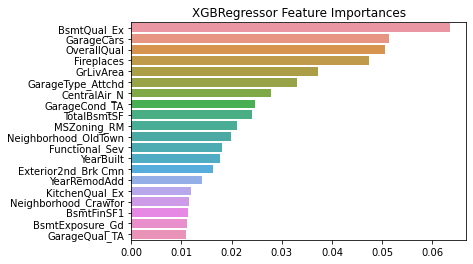

In [ ]:
xgb_reg.fit(X_features, y_target)
XGB_feature_series = pd.Series(data=xgb_reg.feature_importances_, index=X_features.columns)
XGB_feature_series = XGB_feature_series.sort_values(ascending=False)[:20]
sns.barplot(x=XGB_feature_series, y=XGB_feature_series.index)
plt.title("XGBRegressor Feature Importances")
plt.show()

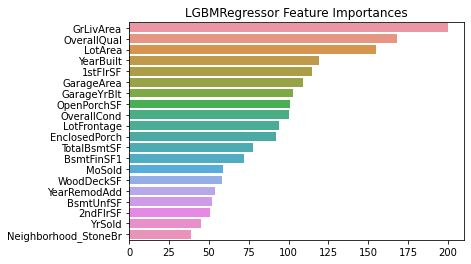

In [ ]:
lgbm_reg.fit(X_features, y_target)
LGBM_feature_series = pd.Series(data=lgbm_reg.feature_importances_, index=X_features.columns)
LGBM_feature_series = LGBM_feature_series.sort_values(ascending=False)[:20]
sns.barplot(x=LGBM_feature_series, y=LGBM_feature_series.index)
plt.title("LGBMRegressor Feature Importances")
plt.show()

### 4. 회귀 모델의 예측 결과 혼합을 통한 최종 예측
- 개별 회귀 모델의 예측 결과값을 혼합하여 이를 기반으로 최종 회귀 값을 예측한다.
- 예를 들어 A 모델과 B 모델, 두 모델의 예측값이 있다면 A 모델 예측값의 40%, B 모델 예측값의 60%를 더하여 최종 회귀 값으로 예측하는 것이다.
- 앞에서 구한 릿지 모델과 라쏘 모델을 서로 혼합한다. 이를 위하여 최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 함수 get_rmse_pred( )를 생성하고, 각 모델의 예측값을 계산한 뒤 개별 모델과 최종 혼합 모델의 RMSE를 구한다.
- XGBoost와 LightGBM을 혼합하여 RMSE를 구한다.

In [ ]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print("{0} 모델의 RMSE: {1}".format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값을 도출
pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = { "최종 혼합" : pred,
         "Ridge" : ridge_pred,
         "Lasso" : lasso_pred}

# 최종 혼합 모델과 개별 모델의 RMSE 값을 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10202865494187516
Ridge 모델의 RMSE: 0.107474018223606
Lasso 모델의 RMSE: 0.10092444580703618


In [ ]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_pred
preds = {"최종 혼합": pred,
         "XGBM": xgb_pred,
         "LGBM": lgbm_pred}

get_rmse_pred(preds)

[12:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 0.10243823192069357
XGBM 모델의 RMSE: 0.10617550132566193
LGBM 모델의 RMSE: 0.10381125488516305


### 5. 스태킹 앙상블 모델을 통한 회귀 예측
- 스태킹 모델을 구현하기 위해서는 개별적인 기반 모델과 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델이 필요하다.
- 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합하여 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이다.
- 최종 메타 모델이 학습할 피처 데이터 세트는 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것이다.
- 개별 모델을 스태킹 모델로 제공하기 위한 데이터 세트를 생성하기 위해 함수 get_stacking_base_datasets( ) 함수를 생성한다. 이 함수는 인자로 개별 기반 모델, 원래 사용되는 학습 데이터와 테스트용 피처 데이터를 입력 받는다. 함수 내에서 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서 원본의 학습 데이터를 다시 추출하여 학습과 예측을 수행한 뒤 그 결과를 저장한다. 저장된 예측 데이터는 추후에 메타 모델의 학습 피처 데이터 세트로 이용된다.
- 또한 함수 내에서 폴드 세트 내부 학습 데이터로 학습된 개별 모델이 인자로 입력된 원본 테스트 데이터를 예측한 뒤, 예측 결과를 평균해 테스트 데이터로 생성한다.
- 개별 모델 릿지, 라쏘, XGBoost, LightGBM에 get_stacking_base_dataset( )을 모델별로 적용하여 메타 모델이 사용할 학습 피처 데이터 세트와 테스트 피처 데이터 세트를 추출한다.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model,X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, " model 시작")

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print("\t 폴드 세트: ", folder_counter, " 시작 ")
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습을 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터를 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터를 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [ ]:
# get_stacking_base_datasets( )는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작
	 폴드 세트:  0  시작 
[15:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[15:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[15:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[15:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[15:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor  model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시

### 5. 스태킹 앙상블 모델을 통한 회귀 예측
- 각 개별 모델이 반환하는 학습용 피처 데이터와 테스트용 피처 데이터 세트를 결합하여 최종 메타 모델에 적용한다. 
- 메타 모델은 별도의 라쏘 모델을 이용하며, 최종적으로 예측 및 RMSE를 측정한다.

In [ ]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print("스태킹 회귀 모델의 최종 RMSE 값은: ", rmse)

스태킹 회귀 모델의 최종 RMSE 값은:  0.10008752145184932
